# New York City Taxi Fare Prediction

## 1. Download the Dataset

In [2]:
#!kaggle competitions download -c new-york-city-taxi-fare-prediction

In [3]:
#import zipfile
#with zipfile.ZipFile('new-york-city-taxi-fare-prediction.zip', 'r') as zip_ref:
#    zip_ref.extractall('taxi-nyc')

In [4]:
!head taxi-nyc/train.csv

key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.733143,-73.991567,40.758092,1
2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.73163,-73.972892,40.758233,1
2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.9513,40.774138,-73.990095,40.751048,1
2012-12-03 13:10:00.000000125,9,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.99

### Load the Training and Testing Data
* Only import 1% of the train dataset and don't include the key

In [55]:
import pandas as pd
import random
sample_fraction = 0.01
selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')
dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'passenger_count': 'uint8'
}
random.seed(42)
def skip_row(row_index):
    if row_index == 0:
        return False
    return random.random() > sample_fraction

random.seed(42)

df = pd.read_csv(
    'taxi-nyc/train.csv', 
    usecols = selected_cols,
    parse_dates = ['pickup_datetime'],
    date_format = '%Y-%m-%d %H:%M:%S %Z',
    dtype = dtypes,
    skiprows = skip_row
    )

In [56]:
test_df = pd.read_csv(
    'taxi-nyc/test.csv',
    dtype = dtypes,
    parse_dates = ['pickup_datetime'],
    date_format = '%Y-%m-%d %H:%M:%S %Z'
)

## 2. Explore and Analyze

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552450 entries, 0 to 552449
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        552450 non-null  float32            
 1   pickup_datetime    552450 non-null  datetime64[ns, UTC]
 2   pickup_longitude   552450 non-null  float32            
 3   pickup_latitude    552450 non-null  float32            
 4   dropoff_longitude  552450 non-null  float32            
 5   dropoff_latitude   552450 non-null  float32            
 6   passenger_count    552450 non-null  uint8              
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 15.3 MB


In [58]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000
mean,11.354059,-72.497063,39.910492,-72.504341,39.934258,1.684983
std,9.811924,11.618246,8.061114,12.074346,9.255058,1.337664
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150635,0.000000
25%,6.000000,-73.992020,40.734875,-73.991425,40.733990,1.000000
50%,8.500000,-73.981819,40.752621,-73.980179,40.753101,1.000000
75%,12.500000,-73.967155,40.767036,-73.963737,40.768059,2.000000
max,499.000000,2420.209473,404.983337,2467.752686,3351.403076,208.000000


In [59]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


<Axes: xlabel='pickup_datetime', ylabel='fare_amount'>

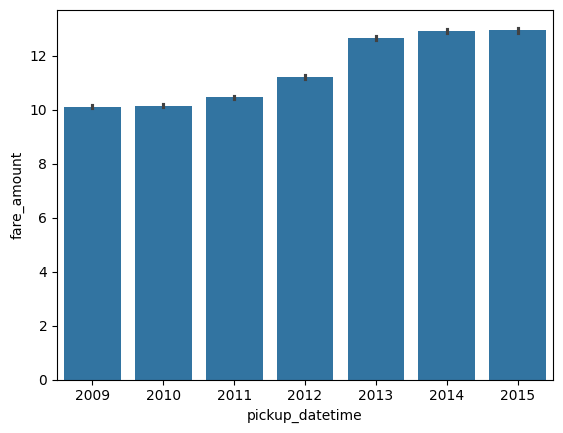

In [60]:
import seaborn as sns
sns.barplot(y = df['fare_amount'], x = df['pickup_datetime'].dt.year)

<Axes: xlabel='passenger_count', ylabel='fare_amount'>

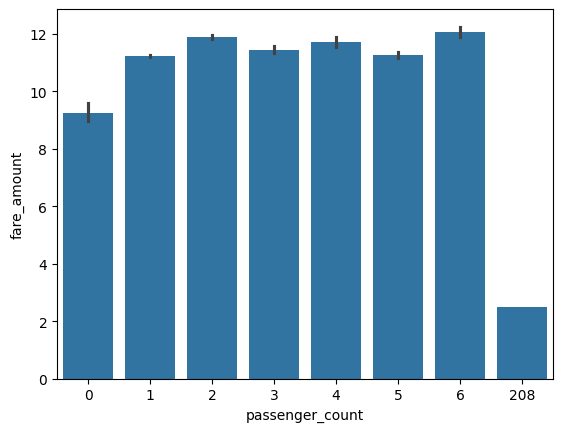

In [61]:
sns.barplot(y = df['fare_amount'], x = df['passenger_count'])

In [62]:
df.loc[df['passenger_count'] == 208]
df = df[df['passenger_count'] != 208]

In [63]:
df = df[
    (df['pickup_latitude'].between(35.0, 45.0)) &
    (df['dropoff_latitude'].between(35.0, 45.0)) &
    (df['pickup_longitude'].between(-80.0, -65.0)) &
    (df['dropoff_longitude'].between(-80.0, -65.0))
]

In [64]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,540961.000000,540961.000000,540961.000000,540961.000000,540961.000000,540961.000000
mean,11.336090,-73.975182,40.750862,-73.974434,40.751228,1.684717
std,9.724271,0.045026,0.035251,0.042746,0.037816,1.308340
min,-52.000000,-77.902481,35.617779,-78.749939,36.992687,0.000000
25%,6.000000,-73.992241,40.736534,-73.991608,40.735519,1.000000
50%,8.500000,-73.982101,40.753342,-73.980614,40.753796,1.000000
75%,12.500000,-73.968376,40.767464,-73.965408,40.768372,2.000000
max,499.000000,-66.522415,44.894650,-70.519135,44.416668,6.000000


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 540961 entries, 0 to 552449
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        540961 non-null  float32            
 1   pickup_datetime    540961 non-null  datetime64[ns, UTC]
 2   pickup_longitude   540961 non-null  float32            
 3   pickup_latitude    540961 non-null  float32            
 4   dropoff_longitude  540961 non-null  float32            
 5   dropoff_latitude   540961 non-null  float32            
 6   passenger_count    540961 non-null  uint8              
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 19.1 MB


## 3. Prepare Data for Training

In [66]:
#Split the training data to training and validation sets
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)
len(train_df), len(valid_df)

(432768, 108193)

In [67]:
#Fill or Remove Missing Values
train_df = train_df.dropna()
valid_df = valid_df.dropna()

In [68]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [69]:
#Extract Inputs and Outputs
input_cols = ['pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
target_cols = ['fare_amount']

In [70]:
train_inputs = train_df[input_cols]
train_target = train_df[target_cols]

valid_inputs = valid_df[input_cols]
valid_target = valid_df[target_cols]

test_inputs = test_df[input_cols]

## 4. Train Baseline Model

In [71]:
from sklearn.metrics import mean_squared_error
def rmse(targets, preds):
    return mean_squared_error(targets, preds) ** 0.5

In [72]:
#Baseline Model: Linear Regression
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(train_inputs, train_target)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [73]:
train_preds = linear_model.predict(train_inputs)
print(rmse(train_target, train_preds))

9.733799704609353


## 5. Make Predictions

In [74]:
def predict_and_submit(model, fname):
    test_preds = model.predict(test_inputs)
    sub_df = pd.read_csv('taxi-nyc/sample_submission.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(f'taxi-nyc/{fname}', index = None)

## 6. Feature Engineering

In [75]:
#Date feature engineering
def add_date_features(df, col):
    df['year'] = df[col].dt.year
    df['month'] = df[col].dt.month
    df['day_of_month'] = df[col].dt.day
    df['day_of_week'] = df[col].dt.weekday
    df['hour'] = df[col].dt.hour
    df['is_weekend'] = df[col].dt.weekday.isin([5,6]).astype('uint8')
    df['is_night'] = ((df[col].dt.hour < 6) | (df[col].dt.hour > 22)).astype('uint8')
    df['rush_hour'] = df[col].dt.hour.isin([7,8,9,16,17,18]).astype('uint8')
    df['week'] = df[col].dt.isocalendar().week.astype('int16')
    df['quarter'] = df[col].dt.quarter
    return df

In [76]:
add_date_features(train_df, 'pickup_datetime')
add_date_features(valid_df, 'pickup_datetime')
add_date_features(test_df, 'pickup_datetime')

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_month,day_of_week,hour,is_weekend,is_night,rush_hour,week,quarter
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13,0,0,0,5,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13,0,0,0,5,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1,2011,10,8,5,11,1,0,0,40,4
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1,2012,12,1,5,21,1,0,0,48,4
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1,2012,12,1,5,21,1,0,0,48,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6,2015,5,10,6,12,1,0,0,19,2
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6,2015,1,12,0,17,0,0,1,3,1
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6,2015,4,19,6,20,1,0,0,16,2
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6,2015,1,31,5,1,1,1,0,5,1


In [77]:
#Haversine Distance
import numpy as np
def haversine_np(lat1, lon1, lat2, lon2):
    """
    Haversine distance in km
    lat/lon inputs can be scalars, pandas Series, or NumPy arrays
    """
    R = 6371.0  # Earth radius in km
    
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c

In [78]:
def add_trip_distance(df):
    df['trip_distance_km'] = haversine_np(
        df['pickup_latitude'],
        df['pickup_longitude'],
        df['dropoff_latitude'],
        df['dropoff_longitude']
    )
    return df

In [79]:
add_trip_distance(train_df)
add_trip_distance(valid_df)
add_trip_distance(test_df)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_month,day_of_week,hour,is_weekend,is_night,rush_hour,week,quarter,trip_distance_km
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13,0,0,0,5,1,2.323358
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13,0,0,0,5,1,2.425299
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1,2011,10,8,5,11,1,0,0,40,4,0.618403
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1,2012,12,1,5,21,1,0,0,48,4,1.960912
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1,2012,12,1,5,21,1,0,0,48,4,5.387211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6,2015,5,10,6,12,1,0,0,19,2,2.124599
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6,2015,1,12,0,17,0,0,1,3,1,3.271138
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6,2015,4,19,6,20,1,0,0,16,2,19.183577
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6,2015,1,31,5,1,1,1,0,5,1,8.343392


In [80]:
#Is Manhattan or Not
def add_is_manhattan(df):
    df['pickup_in_manhattan'] = (
        (df['pickup_longitude'] > -74.03) &
        (df['pickup_longitude'] < -73.93) &
        (df['pickup_latitude'] > 40.70) &
        (df['pickup_latitude'] < 40.85)
    ).astype('uint8')
    
    df['dropoff_in_manhattan'] = (
        (df['dropoff_longitude'] > -74.03) &
        (df['dropoff_longitude'] < -73.93) &
        (df['dropoff_latitude'] > 40.70) &
        (df['dropoff_latitude'] < 40.85)
    ).astype('uint8')
    
    return df

In [81]:
add_is_manhattan(train_df)
add_is_manhattan(valid_df)
add_is_manhattan(test_df)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_month,day_of_week,hour,is_weekend,is_night,rush_hour,week,quarter,trip_distance_km,pickup_in_manhattan,dropoff_in_manhattan
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13,0,0,0,5,1,2.323358,1,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13,0,0,0,5,1,2.425299,1,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1,2011,10,8,5,11,1,0,0,40,4,0.618403,1,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1,2012,12,1,5,21,1,0,0,48,4,1.960912,1,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1,2012,12,1,5,21,1,0,0,48,4,5.387211,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6,2015,5,10,6,12,1,0,0,19,2,2.124599,1,1
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6,2015,1,12,0,17,0,0,1,3,1,3.271138,1,1
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6,2015,4,19,6,20,1,0,0,16,2,19.183577,1,0
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6,2015,1,31,5,1,1,1,0,5,1,8.343392,1,1


In [82]:
# Drop Distance from Popular Landmarks
jfk_lonlat = (-73.7781, 40.6413)
lga_lonlat = (-73.8740, 40.7769)
ewr_lonlat = (-74.1745, 40.6895)
met_lonlat = (-73.9632, 40.7794)
wtc_lonlat = (-74.0099, 40.7126)

def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(
        df['dropoff_latitude'], df['dropoff_longitude'],
        lat, lon
    )

def add_landmarks(df):
    landmarks = [
        ('jfk', jfk_lonlat),
        ('lga', lga_lonlat),
        ('ewr', ewr_lonlat),
        ('met', met_lonlat),
        ('wtc', wtc_lonlat)
    ]
    for name, lonlat in landmarks:
        add_landmark_dropoff_distance(df, name, lonlat)
    return df

In [83]:
add_landmarks(train_df)
add_landmarks(valid_df)
add_landmarks(test_df)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_month,...,week,quarter,trip_distance_km,pickup_in_manhattan,dropoff_in_manhattan,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,...,5,1,2.323358,1,1,20.587837,9.766299,17.357740,4.242006,4.221359
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,...,5,1,2.425299,1,1,21.564516,11.323100,15.799543,5.386261,3.100082
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1,2011,10,8,...,40,4,0.618403,1,1,20.607008,9.532814,17.588009,3.949200,4.517339
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1,2012,12,1,...,48,4,1.960912,1,1,21.702991,10.201497,16.980310,3.846307,4.639962
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1,2012,12,1,...,48,4,5.387211,1,1,21.127256,10.302326,16.818928,4.436549,3.969716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6,2015,5,10,...,19,2,2.124599,1,1,21.520693,6.885229,21.028217,0.646089,8.815457
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6,2015,1,12,...,3,1,3.271138,1,1,21.475666,7.259489,20.477312,0.420605,8.234328
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6,2015,4,19,...,16,2,19.183577,1,0,1.169840,16.094597,32.792957,20.747263,19.946260
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6,2015,1,31,...,5,1,8.343392,1,1,22.416492,6.142375,23.425482,3.202801,11.563444


In [104]:
#Going into Manhattan from outside OR out of Manhattan from inside
def cross_manhattan(df):
    df['trip_crosses_manhattan'] = (df['pickup_in_manhattan'] != df['dropoff_in_manhattan']).astype('uint8')
    return df

In [105]:
cross_manhattan(train_df)
cross_manhattan(valid_df)
cross_manhattan(test_df)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day_of_month,...,quarter,trip_distance_km,pickup_in_manhattan,dropoff_in_manhattan,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance,trip_crosses_manhattan
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,...,1,2.323358,1,1,20.587837,9.766299,17.357740,4.242006,4.221359,0
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,...,1,2.425299,1,1,21.564516,11.323100,15.799543,5.386261,3.100082,0
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1,2011,10,8,...,4,0.618403,1,1,20.607008,9.532814,17.588009,3.949200,4.517339,0
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1,2012,12,1,...,4,1.960912,1,1,21.702991,10.201497,16.980310,3.846307,4.639962,0
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1,2012,12,1,...,4,5.387211,1,1,21.127256,10.302326,16.818928,4.436549,3.969716,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6,2015,5,10,...,2,2.124599,1,1,21.520693,6.885229,21.028217,0.646089,8.815457,0
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6,2015,1,12,...,1,3.271138,1,1,21.475666,7.259489,20.477312,0.420605,8.234328,0
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6,2015,4,19,...,2,19.183577,1,0,1.169840,16.094597,32.792957,20.747263,19.946260,1
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6,2015,1,31,...,1,8.343392,1,1,22.416492,6.142375,23.425482,3.202801,11.563444,0


In [106]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day_of_month', 'day_of_week', 'hour', 'is_weekend',
       'is_night', 'rush_hour', 'week', 'quarter', 'trip_distance_km',
       'pickup_in_manhattan', 'dropoff_in_manhattan', 'jfk_drop_distance',
       'lga_drop_distance', 'ewr_drop_distance', 'met_drop_distance',
       'wtc_drop_distance', 'trip_crosses_manhattan'],
      dtype='object')

In [107]:
numeric_cols = [
    'year', 'passenger_count',
    'is_weekend', 'is_night', 'rush_hour',
    'trip_distance_km', 'pickup_in_manhattan', 'dropoff_in_manhattan',
    'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
    'met_drop_distance', 'wtc_drop_distance', 'trip_crosses_manhattan'
]

categorical_cols = ['month', 'quarter', 'day_of_month', 'day_of_week', 'hour', 'week']

target_cols = ['fare_amount']

In [108]:
#One Hot Encoding
from sklearn.preprocessing import OneHotEncoder
X_train_raw = train_df[categorical_cols + numeric_cols]
y_train = train_df[target_cols]

X_valid_raw = valid_df[categorical_cols + numeric_cols]
y_valid = valid_df[target_cols]

X_test_raw = test_df[categorical_cols + numeric_cols]

encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')
encoder.fit(X_train_raw[categorical_cols])

encoded_columns = list(encoder.get_feature_names_out(categorical_cols))

X_train_raw[encoded_columns] = encoder.transform(X_train_raw[categorical_cols])
X_valid_raw[encoded_columns] = encoder.transform(X_valid_raw[categorical_cols])
X_test_raw[encoded_columns]  = encoder.transform(X_test_raw[categorical_cols])

X_train = X_train_raw[numeric_cols + encoded_columns].copy()
X_valid = X_valid_raw[numeric_cols + encoded_columns].copy()
X_test = X_test_raw[numeric_cols + encoded_columns].copy()

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_41035/2177812903.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_41035/2177812903.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_41035/2177812903.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [109]:
X_train.shape, X_valid.shape, X_test.shape

((432768, 145), (108193, 145), (9914, 145))

## 7. Train and Evaluate Different Models

In [110]:
def evaluate(model):
    train_preds = model.predict(X_train)
    train_rmse = rmse(y_train, train_preds)
    valid_preds = model.predict(X_valid)
    valid_rmse = rmse(y_valid, valid_preds)
    return train_rmse, valid_rmse, train_preds, valid_preds

### Lasso Regression

In [111]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(random_state = 42, alpha = 0.9)
lasso_model.fit(X_train, y_train)

,alpha,0.9
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,42
,selection,'cyclic'


In [112]:
evaluate(lasso_model)

(6.6028330140012805,
 6.788569760222784,
 array([ 9.1813843 , 10.49245578, 11.66220266, ..., 15.31359853,
         7.17794618,  8.56237868], shape=(432768,)),
 array([8.25285335, 7.88531043, 9.17753857, ..., 9.61142664, 8.89242331,
        7.6928057 ], shape=(108193,)))

### Random Forest

In [113]:
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor(random_state = 42, max_depth = 7, n_estimators = 200, n_jobs = -1)
forest_model.fit(X_train, y_train)
evaluate(forest_model)

/opt/homebrew/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



(4.126055510751854,
 4.147080206208842,
 array([ 7.83049775, 10.80492692, 10.90804656, ..., 19.48840622,
         5.21934726,  7.67973502], shape=(432768,)),
 array([5.86398915, 6.76416836, 7.83049775, ..., 6.616779  , 6.58350953,
        6.64844683], shape=(108193,)))

### XGBoost

In [116]:
from xgboost import XGBRegressor
XGB_Model = XGBRegressor(
    n_estimators = 200,
    max_depth = 7,
    n_jobs = -1,
    objective = 'reg:squarederror',
    random_state = 42
)
XGB_Model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [117]:
evaluate(XGB_Model)

(2.742092554779924,
 3.9499075238955483,
 array([ 7.7573075, 12.133394 , 12.341627 , ..., 19.733927 ,  4.7255735,
         6.544695 ], shape=(432768,), dtype=float32),
 array([ 6.5887074,  6.8125916, 10.214657 , ...,  7.2126327,  6.5763626,
         4.7576346], shape=(108193,), dtype=float32))

## 8. Tune Hyperparameters

In [118]:
import matplotlib.pyplot as plt
def plot_rmse_vs_param(param_name, start, stop, step, **fixed_params):

    param_values = list(range(start, stop, step))
    train_rmse_list = []
    valid_rmse_list = []

    for val in param_values:
        model_params = {param_name: val, **fixed_params}

        model = XGBRegressor(
            n_jobs = -1,
            random_state = 42,
            objective = 'reg:squarederror',
            **model_params
        )

        model.fit(X_train, y_train)

        train_rmse = rmse(y_train, model.predict(X_train))
        valid_rmse = rmse(y_valid, model.predict(X_valid))

        train_rmse_list.append(train_rmse)
        valid_rmse_list.append(valid_rmse)

    plt.figure(figsize = (8, 5))
    plt.plot(param_values, train_rmse_list, label = 'Train RMSE')
    plt.plot(param_values, valid_rmse_list, label = 'Validation RMSE')
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    plt.title(f"RMSE vs {param_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [120]:
optimized_parameters = {}

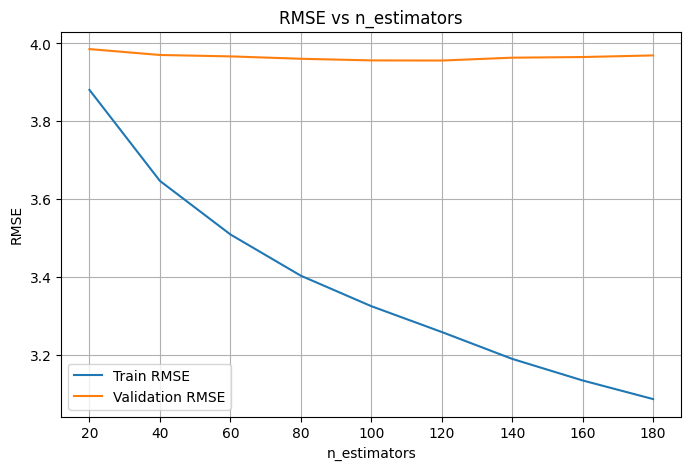

In [122]:
#Optimize n_estimators first
plot_rmse_vs_param('n_estimators', 20, 200, 20, fixed_params = None)

In [123]:
optimized_parameters['n_estimators'] = 75

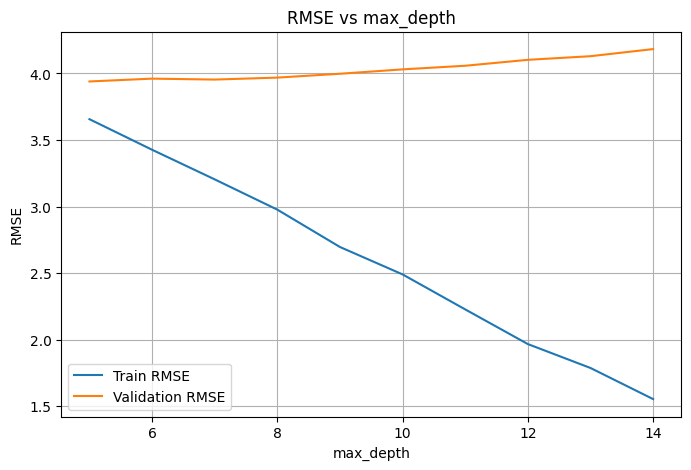

In [124]:
plot_rmse_vs_param('max_depth', 5, 15, 1, n_estimators = 75)

In [126]:
optimized_parameters['max_depth'] = 7

In [154]:
XGB_Model = XGBRegressor(
    n_estimators = 75,
    max_depth = 7,
    n_jobs = -1,
    objective = 'reg:squarederror',
    random_state = 42,
    learning_rate = 0.3,
)
XGB_Model.fit(X_train, y_train)
evaluate(XGB_Model)

(3.2040075063343676,
 3.9540743083773013,
 array([ 7.7595944,  9.948909 , 12.311034 , ..., 19.862276 ,  4.853465 ,
         6.8472033], shape=(432768,), dtype=float32),
 array([6.5330086, 6.784442 , 9.723918 , ..., 6.653244 , 6.650585 ,
        4.962454 ], shape=(108193,), dtype=float32))

In [157]:
predict_and_submit(XGB_Model, 'xgb_model')

ValueError: feature_names mismatch: ['year', 'passenger_count', 'is_weekend', 'is_night', 'rush_hour', 'trip_distance_km', 'pickup_in_manhattan', 'dropoff_in_manhattan', 'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance', 'met_drop_distance', 'wtc_drop_distance', 'trip_crosses_manhattan', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'day_of_month_1', 'day_of_month_2', 'day_of_month_3', 'day_of_month_4', 'day_of_month_5', 'day_of_month_6', 'day_of_month_7', 'day_of_month_8', 'day_of_month_9', 'day_of_month_10', 'day_of_month_11', 'day_of_month_12', 'day_of_month_13', 'day_of_month_14', 'day_of_month_15', 'day_of_month_16', 'day_of_month_17', 'day_of_month_18', 'day_of_month_19', 'day_of_month_20', 'day_of_month_21', 'day_of_month_22', 'day_of_month_23', 'day_of_month_24', 'day_of_month_25', 'day_of_month_26', 'day_of_month_27', 'day_of_month_28', 'day_of_month_29', 'day_of_month_30', 'day_of_month_31', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'week_1', 'week_2', 'week_3', 'week_4', 'week_5', 'week_6', 'week_7', 'week_8', 'week_9', 'week_10', 'week_11', 'week_12', 'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18', 'week_19', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24', 'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_30', 'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36', 'week_37', 'week_38', 'week_39', 'week_40', 'week_41', 'week_42', 'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_50', 'week_51', 'week_52', 'week_53'] ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
expected quarter_4, hour_20, week_18, week_12, week_22, week_39, day_of_month_19, week_19, day_of_month_31, week_48, quarter_1, week_30, day_of_month_3, day_of_month_20, day_of_month_21, day_of_week_0, wtc_drop_distance, day_of_month_4, month_1, week_24, week_37, day_of_month_16, week_38, month_2, day_of_month_6, hour_14, hour_7, day_of_month_14, day_of_month_24, hour_22, week_14, week_26, day_of_month_10, day_of_month_27, met_drop_distance, week_32, week_34, week_7, week_33, day_of_month_7, day_of_month_22, day_of_month_18, year, day_of_month_2, week_21, day_of_month_13, week_45, day_of_month_1, hour_6, week_44, hour_2, hour_11, week_51, week_47, pickup_in_manhattan, week_17, hour_9, day_of_week_6, week_11, day_of_month_11, trip_crosses_manhattan, day_of_month_25, week_50, week_40, day_of_month_30, day_of_week_4, hour_8, ewr_drop_distance, week_36, day_of_month_28, hour_3, hour_4, day_of_month_15, week_13, week_6, week_29, hour_12, hour_13, is_weekend, month_12, hour_15, month_9, week_25, week_43, week_4, trip_distance_km, day_of_month_29, hour_17, month_5, week_23, day_of_month_26, week_15, day_of_month_17, dropoff_in_manhattan, lga_drop_distance, month_4, week_46, hour_23, week_53, month_6, week_28, is_night, month_11, week_42, day_of_month_23, rush_hour, hour_16, day_of_week_1, quarter_3, week_41, week_5, quarter_2, week_8, day_of_month_8, day_of_month_5, hour_5, week_1, day_of_week_5, week_3, week_10, week_2, month_3, week_31, week_49, month_8, jfk_drop_distance, month_7, day_of_month_9, week_35, hour_1, hour_19, hour_18, hour_21, day_of_week_2, hour_10, hour_0, week_27, day_of_month_12, week_9, week_52, week_16, month_10, day_of_week_3, week_20 in input data
training data did not have the following fields: dropoff_longitude, dropoff_latitude, pickup_longitude, pickup_latitude